In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import math

import json
import tensorly as tl
%matplotlib inline

In [3]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [4]:
font = {'family' : 'SimHei',
        'weight' : 'bold',
        'size'   : '15'}
plt.rc('font', **font)               # 步骤一（设置字体的更多属性）
plt.rc('axes', unicode_minus=False)  # 步骤二（解决坐标轴负数的负号显示问题）

# 载入张量回归模型观察模型参数

In [7]:
# 从json文件读取
index=0
submit = './张量回归参数_wnn/result_SEV.json'
with open(submit, "r") as f:
    json_dict = json.load(f)
    
dist=json_dict['dist'][index]
G=np.array(json_dict['G'][index])
B1=np.array(json_dict['B1'][index])
B2=np.array(json_dict['B2'][index])
alpha=json_dict['alpha'][index]
sigma=json_dict['sigma'][index]

print(json_dict['BIC'][index])

295.374335552773


In [10]:
B=tl.tucker_to_tensor((G,[B1,B2]))

<AxesSubplot:>

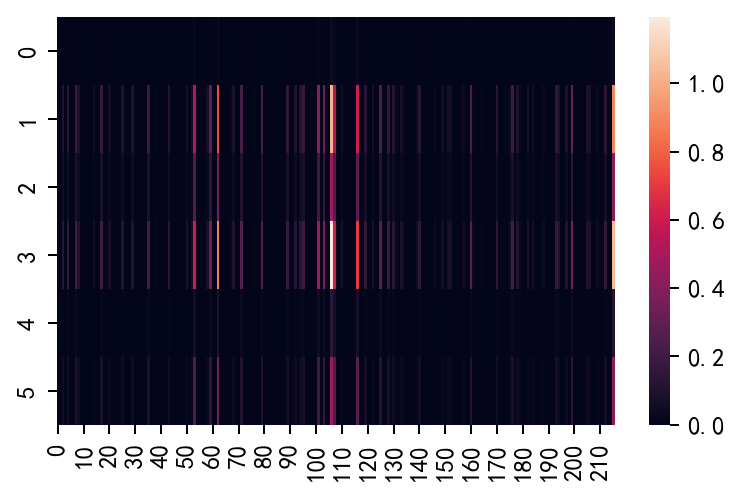

In [21]:
import seaborn as sns
plt.figure(figsize=(5,3),dpi=180)
sns.heatmap(abs(B))

In [17]:
B

array([[-2.96691062e-12,  1.06343405e-10,  4.32447575e-03, ...,
        -3.55973608e-11, -9.68938227e-10, -3.51325190e-02],
       [-7.50524450e-11,  2.69011561e-09,  1.09394087e-01, ...,
        -9.00488523e-10, -2.45107427e-08, -8.88729654e-01],
       [ 3.55036754e-11, -1.27256336e-09, -5.17490423e-02, ...,
         4.25977491e-10,  1.15948448e-08,  4.20414940e-01],
       [ 8.76497684e-11, -3.14164329e-09, -1.27755550e-01, ...,
         1.05163277e-09,  2.86247960e-08,  1.03790021e+00],
       [ 9.81106523e-12, -3.51659425e-10, -1.43003006e-02, ...,
         1.17714375e-10,  3.20411275e-09,  1.16177223e-01],
       [-3.45471802e-11,  1.23827956e-09,  5.03548849e-02, ...,
        -4.14501343e-10, -1.12824712e-08, -4.09088651e-01]])

# 分析HI和特征的相关性 不同机器同特征纵向对比

In [37]:
machine_total=np.array(['正常_R065','正常_R667','不确定_R397','早期_R521',
               '轻微_R048','故障_R072','故障_R368','故障_R419','故障_R396','故障_R420','故障_R085'])
HI_total=np.array([1,0.97886202,0.893528733,0.866090481,0.756001069,0.694213365,0.471909182,0.79511639,0.356578674,0.347377163,0.83559442])
features=[]
for machine in machine_total:
    data=np.load(machine+'_电流.npz')['rotate_feas']
    data=data.mean(axis=0).reshape(1,-1)
    features.append(data)
features=np.vstack(features)

载入数据 周期平均

In [38]:
machine_total=np.array(['正常_R065','正常_R667','不确定_R397','早期_R521',
               '轻微_R048','故障_R072','故障_R368','故障_R419','故障_R396','故障_R420','故障_R085'])
HI_total=np.array([1,0.97886202,0.893528733,0.866090481,0.756001069,0.694213365,0.471909182,0.79511639,0.356578674,0.347377163,0.83559442])
features=[]
for machine in machine_total:
    data=np.load(machine+'_电流.npz')['rotate_feas']
    data=data.mean(axis=0).reshape(1,-1)
    features.append(data)
features=np.vstack(features)

计算相关性

In [39]:
HI_total=np.array(HI_total)
corr=[]
for i in range(features.shape[-1]):
    corr.append(np.corrcoef(HI_total,features[:,i])[0][1])
corr=np.array(corr)
corr_order=np.abs(corr).argsort()[::-1]

载入周期的数据

In [40]:
features_circle=[]
for machine in machine_total:
    data=np.load(machine+'_电流.npz')['rotate_feas']
    data=data.reshape(data.shape[0],-1)
    features_circle.append(data)

index转对应特征函数

In [41]:
def index_convert(index):
    stage_name=['加速',"匀速","减速"]
    fea_name=['峰度','标准差','峰值因子',"偏度","脉冲因子","峰峰值","均方根","波形因数","能量"]
   
    joint=index//216+1  # [1,6]
    motion=(index%216)//27+1 # start from 1
    stage=stage_name[((index%216)%27)//9]
    fea=fea_name[((index%216)%27)%9]
    return [joint,motion,stage,fea]

In [42]:
def convert_index(joint,motion,stage,fea): #start from 1
    index=(joint-1)*216+(motion-1)*27+(stage-1)*9+(fea-1)
    return index

绘图

c:\Users\limer\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:2082: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


AttributeError: Unknown property fontdict

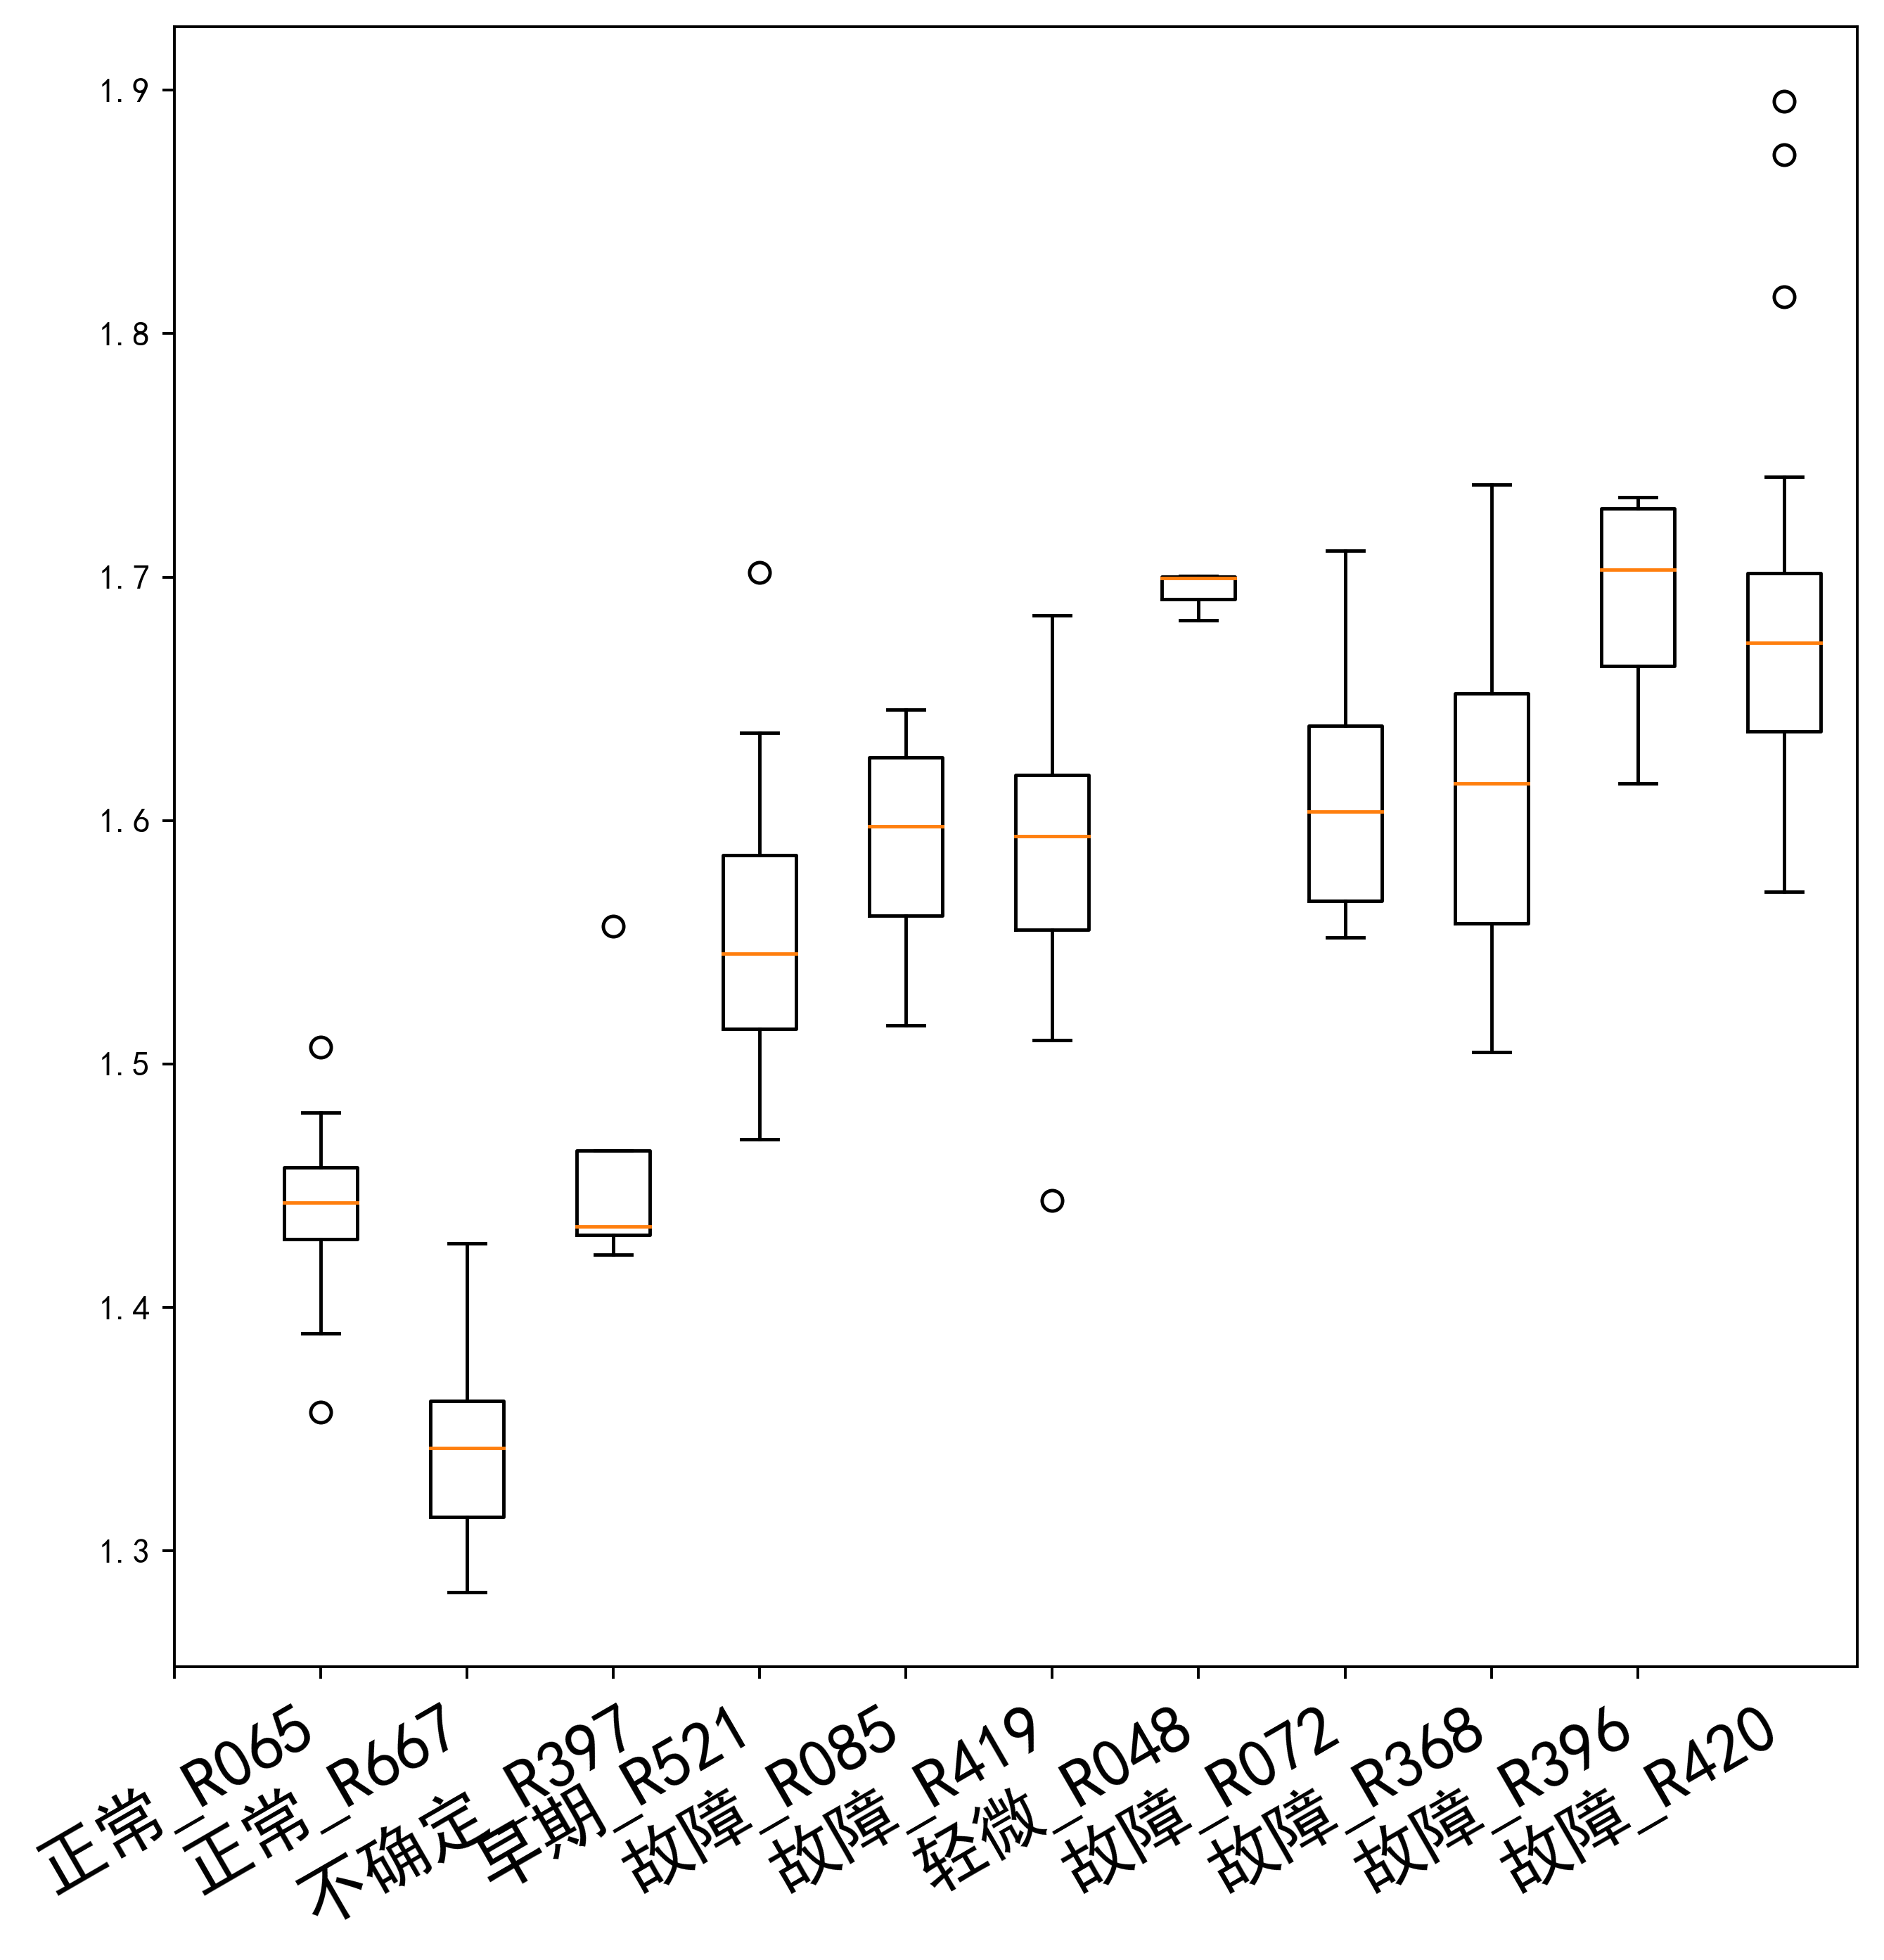

In [43]:
HI_order=HI_total.argsort()[::-1]
stage_name=['加速',"匀速","减速"]
fea_name=['峰度','标准差','峰值因子',"偏度","脉冲因子","峰峰值","均方根","波形因数","能量"]

rank=5
# 展示前5个最相关的特征
plt.figure(figsize=(30,30),dpi=350)
for i in range(rank):
    data_plot=[features_circle[HI_order[m]][:,corr_order[i]] for m in range(len(HI_total))]
    plt.subplot(int(np.ceil(np.sqrt(rank))),int(np.ceil(np.sqrt(rank))),i+1)
    plt.boxplot(data_plot, labels = [machine_total[HI_order[m]] for m in range(len(HI_total))])
    plt.xticks(np.arange(len(HI_order)),[machine_total[HI_order[m]] for m in range(len(HI_total))],
              fontdict={"family": "SimHei", "size": 20, "color": "black"},rotation=30)
    plt.title("corr:{},joint:{}, motion:{}, stage：{},fea:{}".format(
        corr[corr_order[i]],index_convert(corr_order[i])[0],index_convert(corr_order[i])[1],index_convert(corr_order[i])[2],index_convert(corr_order[i])[3]),
              fontdict={"family": "SimHei", "size": 20, "color": "black"})
   
plt.tight_layout()
# plt.savefig('./电流特征对比.png',transparent = False)
plt.show()

    结论：电流在各个子运动的变速、匀速中的统计特征可以体现退化，可以通过对其进行监控进行预警，比如找阈值、控制图等

# 同机器不同特征对比

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

machine_total=np.array(['正常_R065','正常_R667','不确定_R397','早期_R521','轻微_R048','故障_R072','故障_R368','故障_R419','故障_R396','故障_R420','故障_R085'])
state_map = {'正常_R065':1,'正常_R667':1,'不确定_R397':0,'早期_R521':0,'轻微_R048':0,'故障_R072':0,'故障_R368':0,'故障_R419':0,'故障_R396':0,'故障_R420':0\
    ,'故障_R085':0}
machine_train = np.array(['正常_R065','不确定_R397','早期_R521','轻微_R048','故障_R072','故障_R368','故障_R419','故障_R396','故障_R420','故障_R085'])
machine_test = np.array(['正常_R667'])
HI_total=np.array([1,0.97886202,0.893528733,0.866090481,0.756001069,0.694213365,0.471909182,0.79511639,0.356578674,0.347377163,0.83559442])

df = pd.DataFrame([])

for machine in machine_total:
    machine_std = machine
    fea_std = np.load(machine_std+'_电流.npz')['rotate_feas']
    fea_std = np.mean(fea_std, axis=0)
    t_df = pd.DataFrame(fea_std)
    t_df['joint'] = t_df.index
    t_df['machineID'] = machine
    df = df.append(t_df)
df['state'] = df.machineID.map(lambda x: state_map[x])
df = df.reset_index(drop=True)
df

,0,1,2,3,4,5,6,7,8,9,...,209,210,211,212,213,214,215,joint,machineID,state
0,0.004088,0.086227,0.071261,-0.015284,0.076108,0.332280,0.240608,1.067419,2.202184,0.000603,...,0.553333,-0.000021,0.708629,0.072087,0.022734,1.284016,0.019766,0,正常_R065,1
1,0.000797,0.045273,1.299628,0.004516,1.355519,0.168720,0.161215,1.042667,0.988153,0.000049,...,1.427241,-0.002676,1.484733,0.463055,0.164039,1.040276,1.022624,1,正常_R065,1
2,0.002136,0.055575,1.302362,0.009483,1.352776,0.205735,0.206778,1.038503,1.625937,0.000513,...,1.245915,0.000386,1.258014,0.041419,0.072185,1.009705,0.198023,2,正常_R065,1
3,0.000169,0.056716,1.444480,0.001358,1.514812,0.208210,0.108078,1.048535,0.444224,0.000037,...,-0.654264,-0.000338,-0.666121,0.055763,0.068330,1.018169,0.177626,3,正常_R065,1
4,0.000067,0.035741,1.383015,0.000682,1.527967,0.115347,0.084354,1.104268,0.270765,0.000064,...,1.532487,0.000061,1.574607,0.036091,0.038253,1.027448,0.055619,4,正常_R065,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,0.001498,0.055185,1.337461,0.007235,1.391560,0.241333,0.188794,1.040394,1.247721,0.000117,...,1.848225,-0.001270,2.137445,0.571899,0.138274,1.159613,0.674222,1,故障_R085,0
62,0.003330,0.065288,1.377749,0.013072,1.426494,0.295685,0.230014,1.035188,1.852249,0.000881,...,1.234681,0.000645,1.245669,0.050781,0.085659,1.008868,0.256925,2,故障_R085,0
63,0.000229,0.054301,1.502386,0.001713,1.587729,0.225555,0.115865,1.056811,0.469893,0.000044,...,-0.376207,-0.000430,-0.389323,0.086395,0.072965,1.038898,0.186357,3,故障_R085,0
64,0.000117,0.027998,1.375943,0.001056,1.431547,0.114136,0.099051,1.040332,0.343477,0.000098,...,1.987235,0.000046,2.112792,0.060059,0.033851,1.062984,0.040147,4,故障_R085,0


## 生成总的box plot

In [ ]:
# plt.figure(figsize=(100,250))
# for col in tqdm(df.columns[:216]):
#     ax = plt.subplot(36,6,col+1)
#     ax = sns.boxplot(x='joint', y=col, hue="state", data=df)
#     ax = sns.swarmplot(x='joint', y=col, hue="machineID", data=df)
#     # plt.title('feature:{} joint:{}'.format(col,select_joint))
# plt.savefig("box_plot.png")

## 每个关节单独分析

In [3]:
def index_convert(index):
    stage_name=['加速',"匀速","减速"]
    fea_name=['峰度','标准差','峰值因子',"偏度","脉冲因子","峰峰值","均方根","波形因数","能量"]
   
    joint=index//216+1  # [1,6]
    motion=(index%216)//27+1 # start from 1
    stage=stage_name[((index%216)%27)//9]
    fea=fea_name[((index%216)%27)%9]
    return [joint,motion,stage,fea]

def convert_index(joint,motion,stage,fea): #start from 1
    index=(joint-1)*216+(motion-1)*27+(stage-1)*9+(fea-1)
    return index

In [69]:
df

,0,1,2,3,4,5,6,7,8,9,...,209,210,211,212,213,214,215,joint,machineID,state
0,0.004088,0.086227,0.071261,-0.015284,0.076108,0.332280,0.240608,1.067419,2.202184,0.000603,...,0.553333,-0.000021,0.708629,0.072087,0.022734,1.284016,0.019766,0,正常_R065,1
1,0.000797,0.045273,1.299628,0.004516,1.355519,0.168720,0.161215,1.042667,0.988153,0.000049,...,1.427241,-0.002676,1.484733,0.463055,0.164039,1.040276,1.022624,1,正常_R065,1
2,0.002136,0.055575,1.302362,0.009483,1.352776,0.205735,0.206778,1.038503,1.625937,0.000513,...,1.245915,0.000386,1.258014,0.041419,0.072185,1.009705,0.198023,2,正常_R065,1
3,0.000169,0.056716,1.444480,0.001358,1.514812,0.208210,0.108078,1.048535,0.444224,0.000037,...,-0.654264,-0.000338,-0.666121,0.055763,0.068330,1.018169,0.177626,3,正常_R065,1
4,0.000067,0.035741,1.383015,0.000682,1.527967,0.115347,0.084354,1.104268,0.270765,0.000064,...,1.532487,0.000061,1.574607,0.036091,0.038253,1.027448,0.055619,4,正常_R065,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,0.001498,0.055185,1.337461,0.007235,1.391560,0.241333,0.188794,1.040394,1.247721,0.000117,...,1.848225,-0.001270,2.137445,0.571899,0.138274,1.159613,0.674222,1,故障_R085,0
62,0.003330,0.065288,1.377749,0.013072,1.426494,0.295685,0.230014,1.035188,1.852249,0.000881,...,1.234681,0.000645,1.245669,0.050781,0.085659,1.008868,0.256925,2,故障_R085,0
63,0.000229,0.054301,1.502386,0.001713,1.587729,0.225555,0.115865,1.056811,0.469893,0.000044,...,-0.376207,-0.000430,-0.389323,0.086395,0.072965,1.038898,0.186357,3,故障_R085,0
64,0.000117,0.027998,1.375943,0.001056,1.431547,0.114136,0.099051,1.040332,0.343477,0.000098,...,1.987235,0.000046,2.112792,0.060059,0.033851,1.062984,0.040147,4,故障_R085,0


In [84]:
def joint_analysis(select_joint=0,joint_fault_dict={},df=pd.DataFrame([]),joint_compa_dict={},rank=10):
    # joint analysis
    print("正在分析关节",select_joint+1)

    if len(joint_fault_dict[str(select_joint)]) == 2:
        print("no joint {} fault mode can be refered!!".format(select_joint+1))
        return joint_compa_dict

    s_df = df[df.joint == select_joint]
    X = StandardScaler().fit_transform(s_df.drop(columns=['joint','machineID','state']))
    ob_X = X[joint_fault_dict[str(select_joint)],:]
    ob_df = pd.DataFrame(ob_X)

    if len(ob_df) > 3:
        dis_list = np.array(abs(np.mean(ob_df.loc[2:,:]) - np.mean(ob_df.loc[0:1,:])))
    else:
        dis_list = np.array(abs(ob_df.loc[2,:] - np.mean(ob_df.loc[0:1,:])))

    factor_index_list = np.argsort(-dis_list)
    
    for i in range(rank):
        print("rate:{},total_index:{},joint_index：{}，joint:{}, motion:{}, stage：{},fea:{}".format(
            dis_list[factor_index_list[i]],factor_index_list[i]+select_joint*216,factor_index_list[i],select_joint+1,index_convert(factor_index_list[i])[1],
            index_convert(factor_index_list[i])[2],index_convert(factor_index_list[i])[3]))
    joint_compa_dict[str(select_joint)] = factor_index_list[:10]

    plt.figure(figsize=(30,10))
    plt.suptitle('Key fators for Joint {}'.format(select_joint+1))
    for i in tqdm(range(rank)):
        ax = plt.subplot(2,5,i+1)
        ax = sns.boxplot(x='state', y=factor_index_list[i], data=df[df.joint==select_joint])
        ax = sns.swarmplot(x='state', y=factor_index_list[i], hue="machineID", data=df[df.joint==select_joint])
    plt.savefig("box_plot_joint_analysis_J{}.png".format(select_joint+1))

    return joint_compa_dict

正在分析关节 1
rate:3.540186183400273,total_index:53,joint_index：53，joint:1, motion:2, stage：减速,fea:能量
rate:3.5168953388061124,total_index:48,joint_index：48，joint:1, motion:2, stage：减速,fea:偏度
rate:3.5033868204552987,total_index:45,joint_index：45，joint:1, motion:2, stage：减速,fea:峰度
rate:3.408937659251449,total_index:51,joint_index：51，joint:1, motion:2, stage：减速,fea:均方根
rate:3.4009066118600666,total_index:46,joint_index：46，joint:1, motion:2, stage：减速,fea:标准差
rate:3.3898574321508725,total_index:91,joint_index：91，joint:1, motion:4, stage：匀速,fea:标准差
rate:3.373890425149329,total_index:50,joint_index：50，joint:1, motion:2, stage：减速,fea:峰峰值
rate:3.3418398290403477,total_index:37,joint_index：37，joint:1, motion:2, stage：匀速,fea:标准差
rate:3.2149052845604382,total_index:95,joint_index：95，joint:1, motion:4, stage：匀速,fea:峰峰值
rate:3.2023480464734613,total_index:181,joint_index：181，joint:1, motion:7, stage：减速,fea:标准差


100%|██████████| 10/10 [00:00<00:00, 14.85it/s]


正在分析关节 2
rate:3.4984001662284734,total_index:288,joint_index：72，joint:2, motion:3, stage：减速,fea:峰度
rate:3.485689678966765,total_index:291,joint_index：75，joint:2, motion:3, stage：减速,fea:偏度
rate:3.4584865731779617,total_index:342,joint_index：126，joint:2, motion:5, stage：减速,fea:峰度
rate:3.4545816481173013,total_index:396,joint_index：180，joint:2, motion:7, stage：减速,fea:峰度
rate:3.401123965923728,total_index:345,joint_index：129，joint:2, motion:5, stage：减速,fea:偏度
rate:3.3639245293830276,total_index:399,joint_index：183，joint:2, motion:7, stage：减速,fea:偏度
rate:3.348229051510315,total_index:234,joint_index：18，joint:2, motion:1, stage：减速,fea:峰度
rate:3.2781892370860004,total_index:289,joint_index：73，joint:2, motion:3, stage：减速,fea:标准差
rate:3.2738581389795662,total_index:410,joint_index：194，joint:2, motion:8, stage：加速,fea:峰峰值
rate:3.2714203860442277,total_index:416,joint_index：200，joint:2, motion:8, stage：匀速,fea:峰值因子


100%|██████████| 10/10 [00:00<00:00, 14.07it/s]


正在分析关节 3
no joint 3 fault mode can be refered!!
正在分析关节 4
rate:2.263415764160992,total_index:857,joint_index：209，joint:4, motion:8, stage：减速,fea:峰值因子
rate:2.2555950276229373,total_index:859,joint_index：211，joint:4, motion:8, stage：减速,fea:脉冲因子
rate:2.167082138905158,total_index:736,joint_index：88，joint:4, motion:4, stage：加速,fea:波形因数
rate:2.1427786647881333,total_index:682,joint_index：34，joint:4, motion:2, stage：加速,fea:波形因数
rate:1.9906333391335416,total_index:790,joint_index：142，joint:4, motion:6, stage：加速,fea:波形因数
rate:1.7452594573729754,total_index:844,joint_index：196，joint:4, motion:8, stage：加速,fea:波形因数
rate:1.6735147109845494,total_index:737,joint_index：89，joint:4, motion:4, stage：加速,fea:能量
rate:1.6211997020623081,total_index:845,joint_index：197，joint:4, motion:8, stage：加速,fea:能量
rate:1.582623059693712,total_index:817,joint_index：169，joint:4, motion:7, stage：加速,fea:波形因数
rate:1.5453089716730253,total_index:860,joint_index：212，joint:4, motion:8, stage：减速,fea:峰峰值


100%|██████████| 10/10 [00:00<00:00, 13.30it/s]


正在分析关节 5
rate:3.5775744825003084,total_index:867,joint_index：3，joint:5, motion:1, stage：加速,fea:偏度
rate:3.575407178288105,total_index:864,joint_index：0，joint:5, motion:1, stage：加速,fea:峰度
rate:3.5725818974650587,total_index:872,joint_index：8，joint:5, motion:1, stage：加速,fea:能量
rate:3.5571987167121346,total_index:972,joint_index：108，joint:5, motion:5, stage：加速,fea:峰度
rate:3.555264471778578,total_index:975,joint_index：111，joint:5, motion:5, stage：加速,fea:偏度
rate:3.5469583528930895,total_index:870,joint_index：6，joint:5, motion:1, stage：加速,fea:均方根
rate:3.5255389928458203,total_index:918,joint_index：54，joint:5, motion:3, stage：加速,fea:峰度
rate:3.5236894884954713,total_index:1026,joint_index：162，joint:5, motion:7, stage：加速,fea:峰度
rate:3.5112282110101463,total_index:1017,joint_index：153，joint:5, motion:6, stage：减速,fea:峰度
rate:3.5079827873725735,total_index:909,joint_index：45，joint:5, motion:2, stage：减速,fea:峰度


100%|██████████| 10/10 [00:00<00:00, 15.28it/s]


正在分析关节 6
no joint 6 fault mode can be refered!!


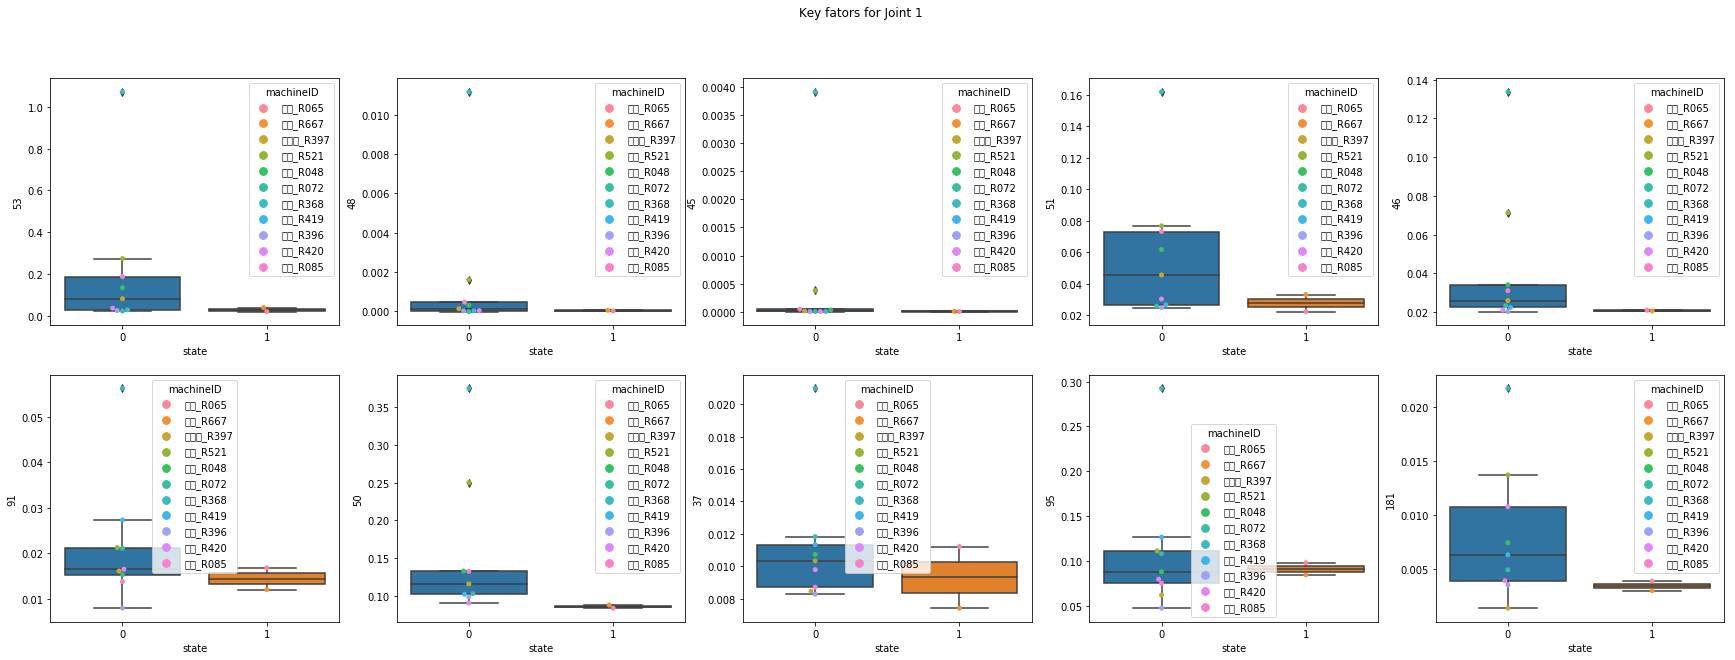

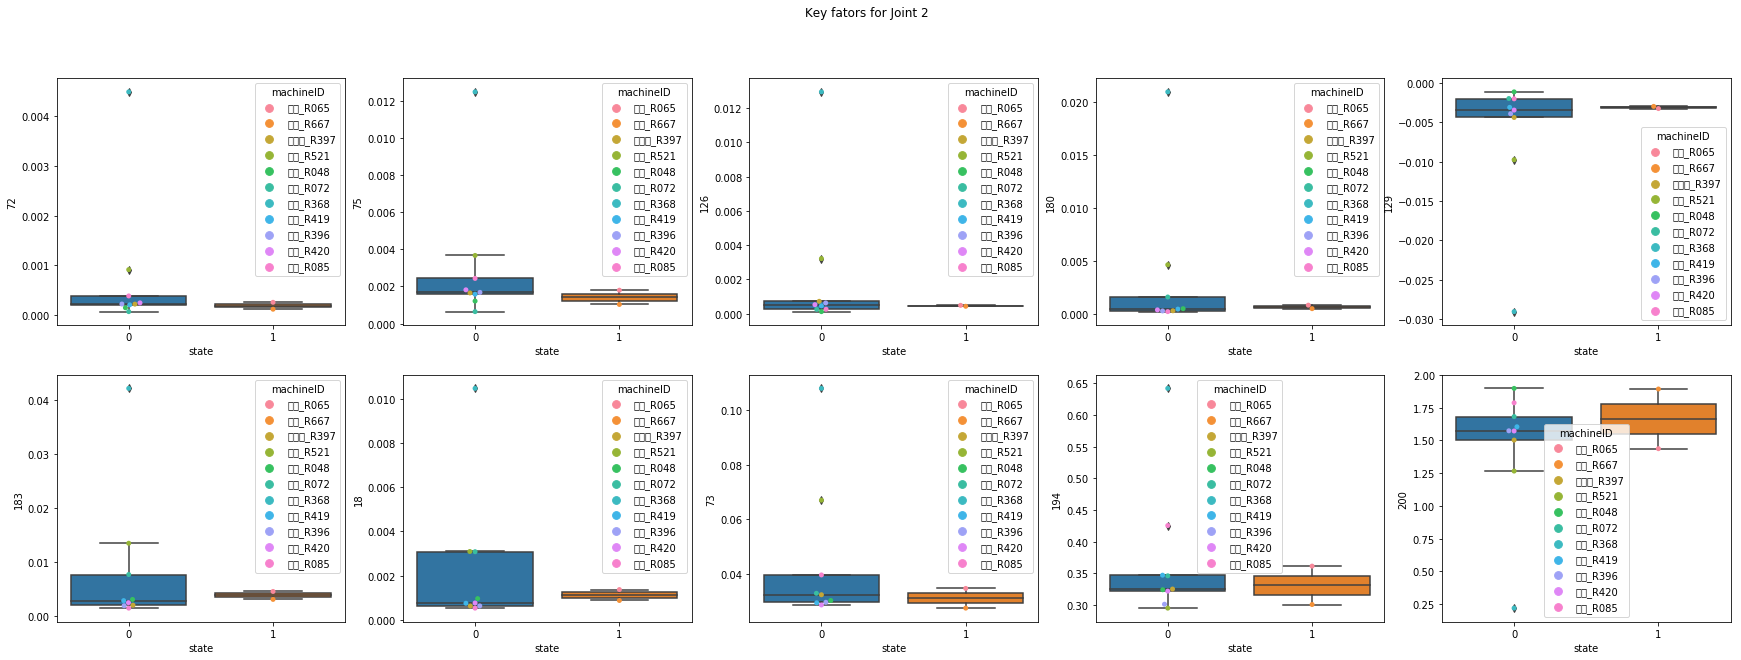

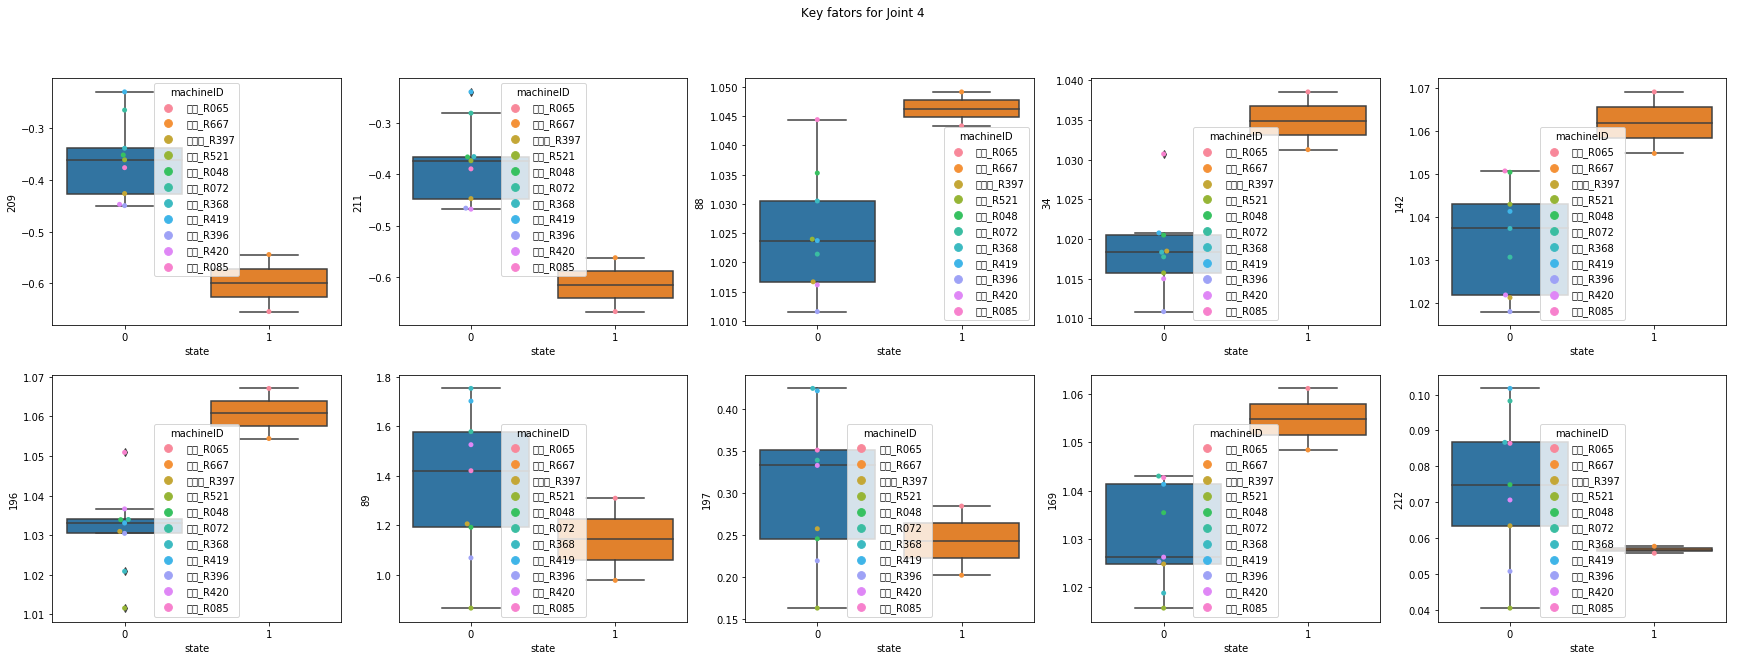

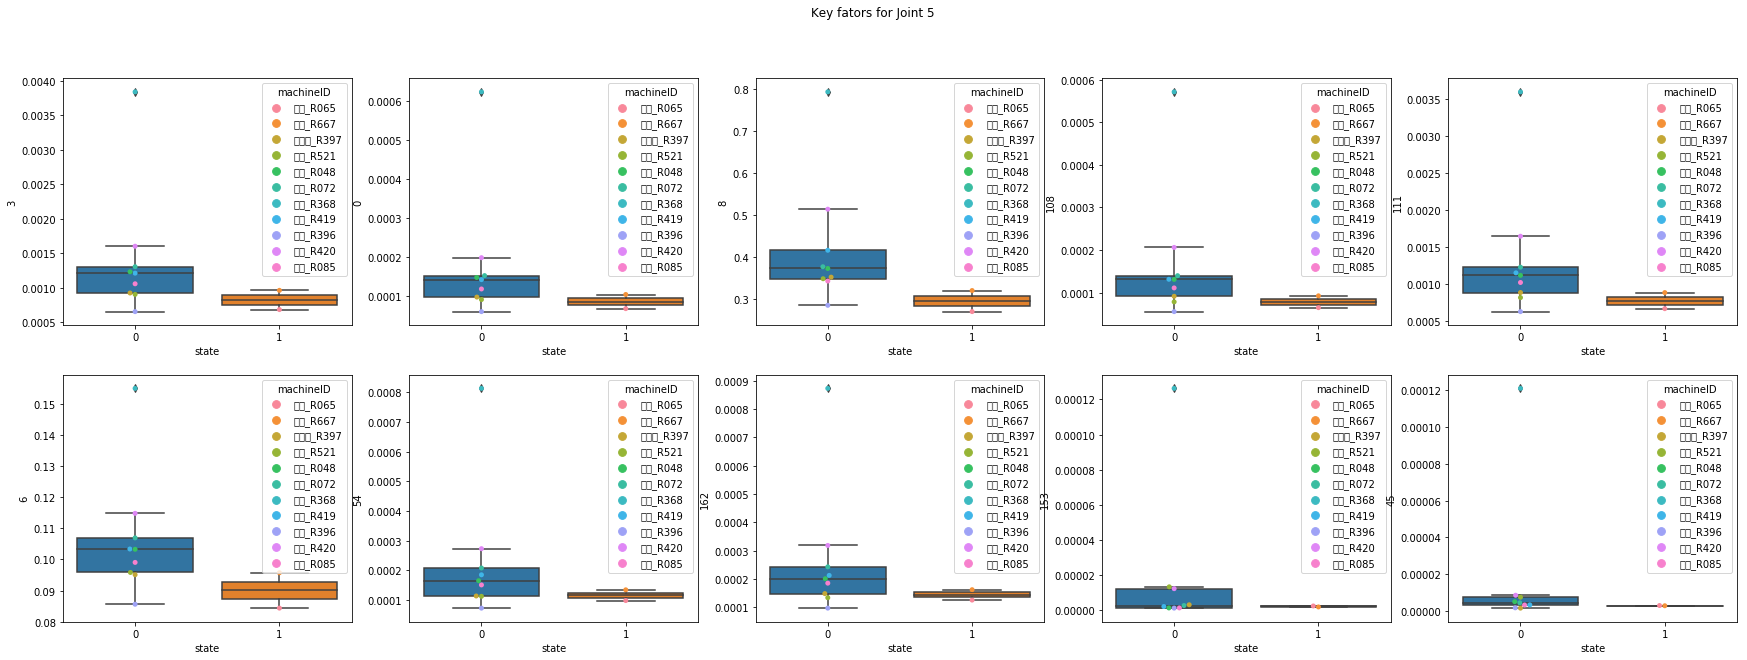

In [85]:
joint_fault_dict = {'0':[0,1,6],
                    '1':[0,1,6],
                    '2':[0,1],
                    '3':[0,1,7,9],
                    '4':[0,1,6],
                    '5':[0,1]}  # 正常关节和选取关节对应的行
joint_compa_dict = {}
for i in range(6):
    joint_compa_dict = joint_analysis(select_joint=i,joint_fault_dict=joint_fault_dict,df=df,joint_compa_dict=joint_compa_dict,rank=10)

identify fault type

In [94]:
# identification factor dict
joint_compa_dict = {'0':[53,48,45,51,46,91,50,37,95,181,8,116],
                    '1':[72,75,126,180,129,183,18,73,194,200,111,163,165,114],
                    '2':[169,88,166],
                    '3':[209,211,88,34,142,196,89,197,169,212,166,136,82],
                    '4':[3,0,8,108,111,6,54,162,153,45,119,109],
                    '5':[115,13,11,110,112,172,16,88,168]} # joint 6 是通过后面broken analysis补充的

In [95]:
def joint_fault_mode_dignosis(select_joint=0,df=pd.DataFrame([]),joint_compa_dict={},rank=20):
    print("诊断关节：",select_joint+1)

    if str(select_joint) not in joint_compa_dict.keys():
        print("no joint {} fault mode can be refered!!".format(select_joint+1))
        return

    joint_compa_list = joint_compa_dict[str(select_joint)]
    s_df = df[df.joint == select_joint]
    X = StandardScaler().fit_transform(s_df.drop(columns=['joint','machineID','state']))
    ob_df = pd.DataFrame(X)
    factor_dict = {}

    for i in range(2,11):
        dis_list = np.array(abs(ob_df.loc[i,:] - np.mean(ob_df.loc[0:1,:])))
        factor_index_list = np.argsort(-dis_list)
        overlap_factor_list = [x for x in joint_compa_list if x in factor_index_list[:rank]]
        print("Machine",machine_total[i],": Overlap factor number:", len(overlap_factor_list),"/",len(joint_compa_list))
        factor_dict[machine_total[i]] = factor_index_list[:rank]

for i in range(6):
    joint_fault_mode_dignosis(select_joint=i,df=df,joint_compa_dict=joint_compa_dict,rank=20)

诊断关节： 1
Machine 不确定_R397 : Overlap factor number: 2 / 12
Machine 早期_R521 : Overlap factor number: 0 / 12
Machine 轻微_R048 : Overlap factor number: 0 / 12
Machine 故障_R072 : Overlap factor number: 0 / 12
Machine 故障_R368 : Overlap factor number: 10 / 12
Machine 故障_R419 : Overlap factor number: 0 / 12
Machine 故障_R396 : Overlap factor number: 0 / 12
Machine 故障_R420 : Overlap factor number: 1 / 12
Machine 故障_R085 : Overlap factor number: 0 / 12
诊断关节： 2
Machine 不确定_R397 : Overlap factor number: 3 / 14
Machine 早期_R521 : Overlap factor number: 3 / 14
Machine 轻微_R048 : Overlap factor number: 2 / 14
Machine 故障_R072 : Overlap factor number: 0 / 14
Machine 故障_R368 : Overlap factor number: 10 / 14
Machine 故障_R419 : Overlap factor number: 3 / 14
Machine 故障_R396 : Overlap factor number: 4 / 14
Machine 故障_R420 : Overlap factor number: 4 / 14
Machine 故障_R085 : Overlap factor number: 1 / 14
诊断关节： 3
Machine 不确定_R397 : Overlap factor number: 2 / 3
Machine 早期_R521 : Overlap factor number: 1 / 3
Machine 轻微_R0

## Broken Analysis（整体退化趋势）

In [4]:
n_df = pd.DataFrame([])
for machine in machine_total:
    machine_std = machine
    fea_std = np.load(machine_std+'_电流.npz')['rotate_feas']
    fea_std = np.mean(fea_std, axis=0).reshape(1,-1)
    t_df = pd.DataFrame(fea_std)
    t_df['machineID'] = machine
    n_df = n_df.append(t_df)
n_df['state'] = n_df.machineID.map(lambda x: state_map[x])
n_df = n_df.reset_index(drop=True)
n_df

,0,1,2,3,4,5,6,7,8,9,...,1288,1289,1290,1291,1292,1293,1294,1295,machineID,state
0,0.004088,0.086227,0.071261,-0.015284,0.076108,0.332280,0.240608,1.067419,2.202184,0.000603,...,0.012842,1.423381,0.000228,1.456957,0.053425,0.059756,1.023494,0.135737,正常_R065,1
1,0.006614,0.084335,0.040915,-0.022178,0.042833,0.354259,0.274686,1.046766,2.640965,0.001017,...,0.008420,1.464627,0.000075,1.495174,0.035331,0.041356,1.020823,0.059868,正常_R667,1
2,0.011431,0.085564,0.000197,-0.033425,0.000205,0.414886,0.315620,1.037812,3.885141,0.002327,...,0.008729,1.640016,0.000057,1.685260,0.038361,0.037470,1.027615,0.054768,不确定_R397,0
3,0.002076,0.058141,-0.221591,-0.009292,-0.232046,0.206533,0.205034,1.045361,1.599318,0.000060,...,0.010598,1.637866,0.000017,1.824469,0.039668,0.024220,1.111084,0.022434,早期_R521,0
4,0.017388,0.111090,0.066883,-0.045063,0.070261,0.507365,0.346007,1.050245,4.192094,0.005070,...,0.014586,1.540371,0.000169,1.600455,0.058105,0.053461,1.038855,0.100076,轻微_R048,0
5,0.011446,0.088727,0.087010,-0.033799,0.089992,0.426043,0.317867,1.034397,3.334517,0.000352,...,0.009322,1.557133,0.000069,1.600733,0.040545,0.039869,1.027956,0.052477,故障_R072,0
6,0.011137,0.097304,-0.284802,-0.031443,-0.303879,0.343807,0.301533,1.065346,3.024999,0.000570,...,0.013409,1.782199,0.000046,1.981751,0.048519,0.032213,1.108161,0.035600,故障_R368,0
7,0.008372,0.081815,0.061104,-0.026339,0.063386,0.401484,0.291102,1.037158,3.305864,0.001334,...,0.011844,1.493380,0.000100,1.547302,0.050396,0.044991,1.035991,0.078991,故障_R419,0
8,0.005697,0.067865,0.086095,-0.020155,0.088805,0.343536,0.268358,1.028498,2.808696,0.000407,...,0.011102,1.445815,0.000048,1.522960,0.039032,0.034910,1.053311,0.047534,故障_R396,0
9,0.007201,0.071420,0.049159,-0.023891,0.050621,0.372944,0.283395,1.029775,3.132681,0.000907,...,0.012488,1.586472,0.000045,1.703691,0.046035,0.033585,1.073801,0.044018,故障_R420,0


[1096  857  859  682 1093  327 1091  844 1195  324  332  330 1192  817
  814  551  553  790  736  871 1168  381 1190 1222 1242   82  983 1141
  379  985]
index：1096，joint:6, joint_index:16, motion:1, stage：匀速,fea:波形因数
index：857，joint:4, joint_index:209, motion:8, stage：减速,fea:峰值因子
index：859，joint:4, joint_index:211, motion:8, stage：减速,fea:脉冲因子
index：682，joint:4, joint_index:34, motion:2, stage：加速,fea:波形因数
index：1093，joint:6, joint_index:13, motion:1, stage：匀速,fea:脉冲因子
index：327，joint:2, joint_index:111, motion:5, stage：加速,fea:偏度
index：1091，joint:6, joint_index:11, motion:1, stage：匀速,fea:峰值因子
index：844，joint:4, joint_index:196, motion:8, stage：加速,fea:波形因数
index：1195，joint:6, joint_index:115, motion:5, stage：加速,fea:波形因数
index：324，joint:2, joint_index:108, motion:5, stage：加速,fea:峰度
index：332，joint:2, joint_index:116, motion:5, stage：加速,fea:能量
index：330，joint:2, joint_index:114, motion:5, stage：加速,fea:均方根
index：1192，joint:6, joint_index:112, motion:5, stage：加速,fea:脉冲因子
index：817，joint:4, j

100%|██████████| 30/30 [00:02<00:00, 12.87it/s]


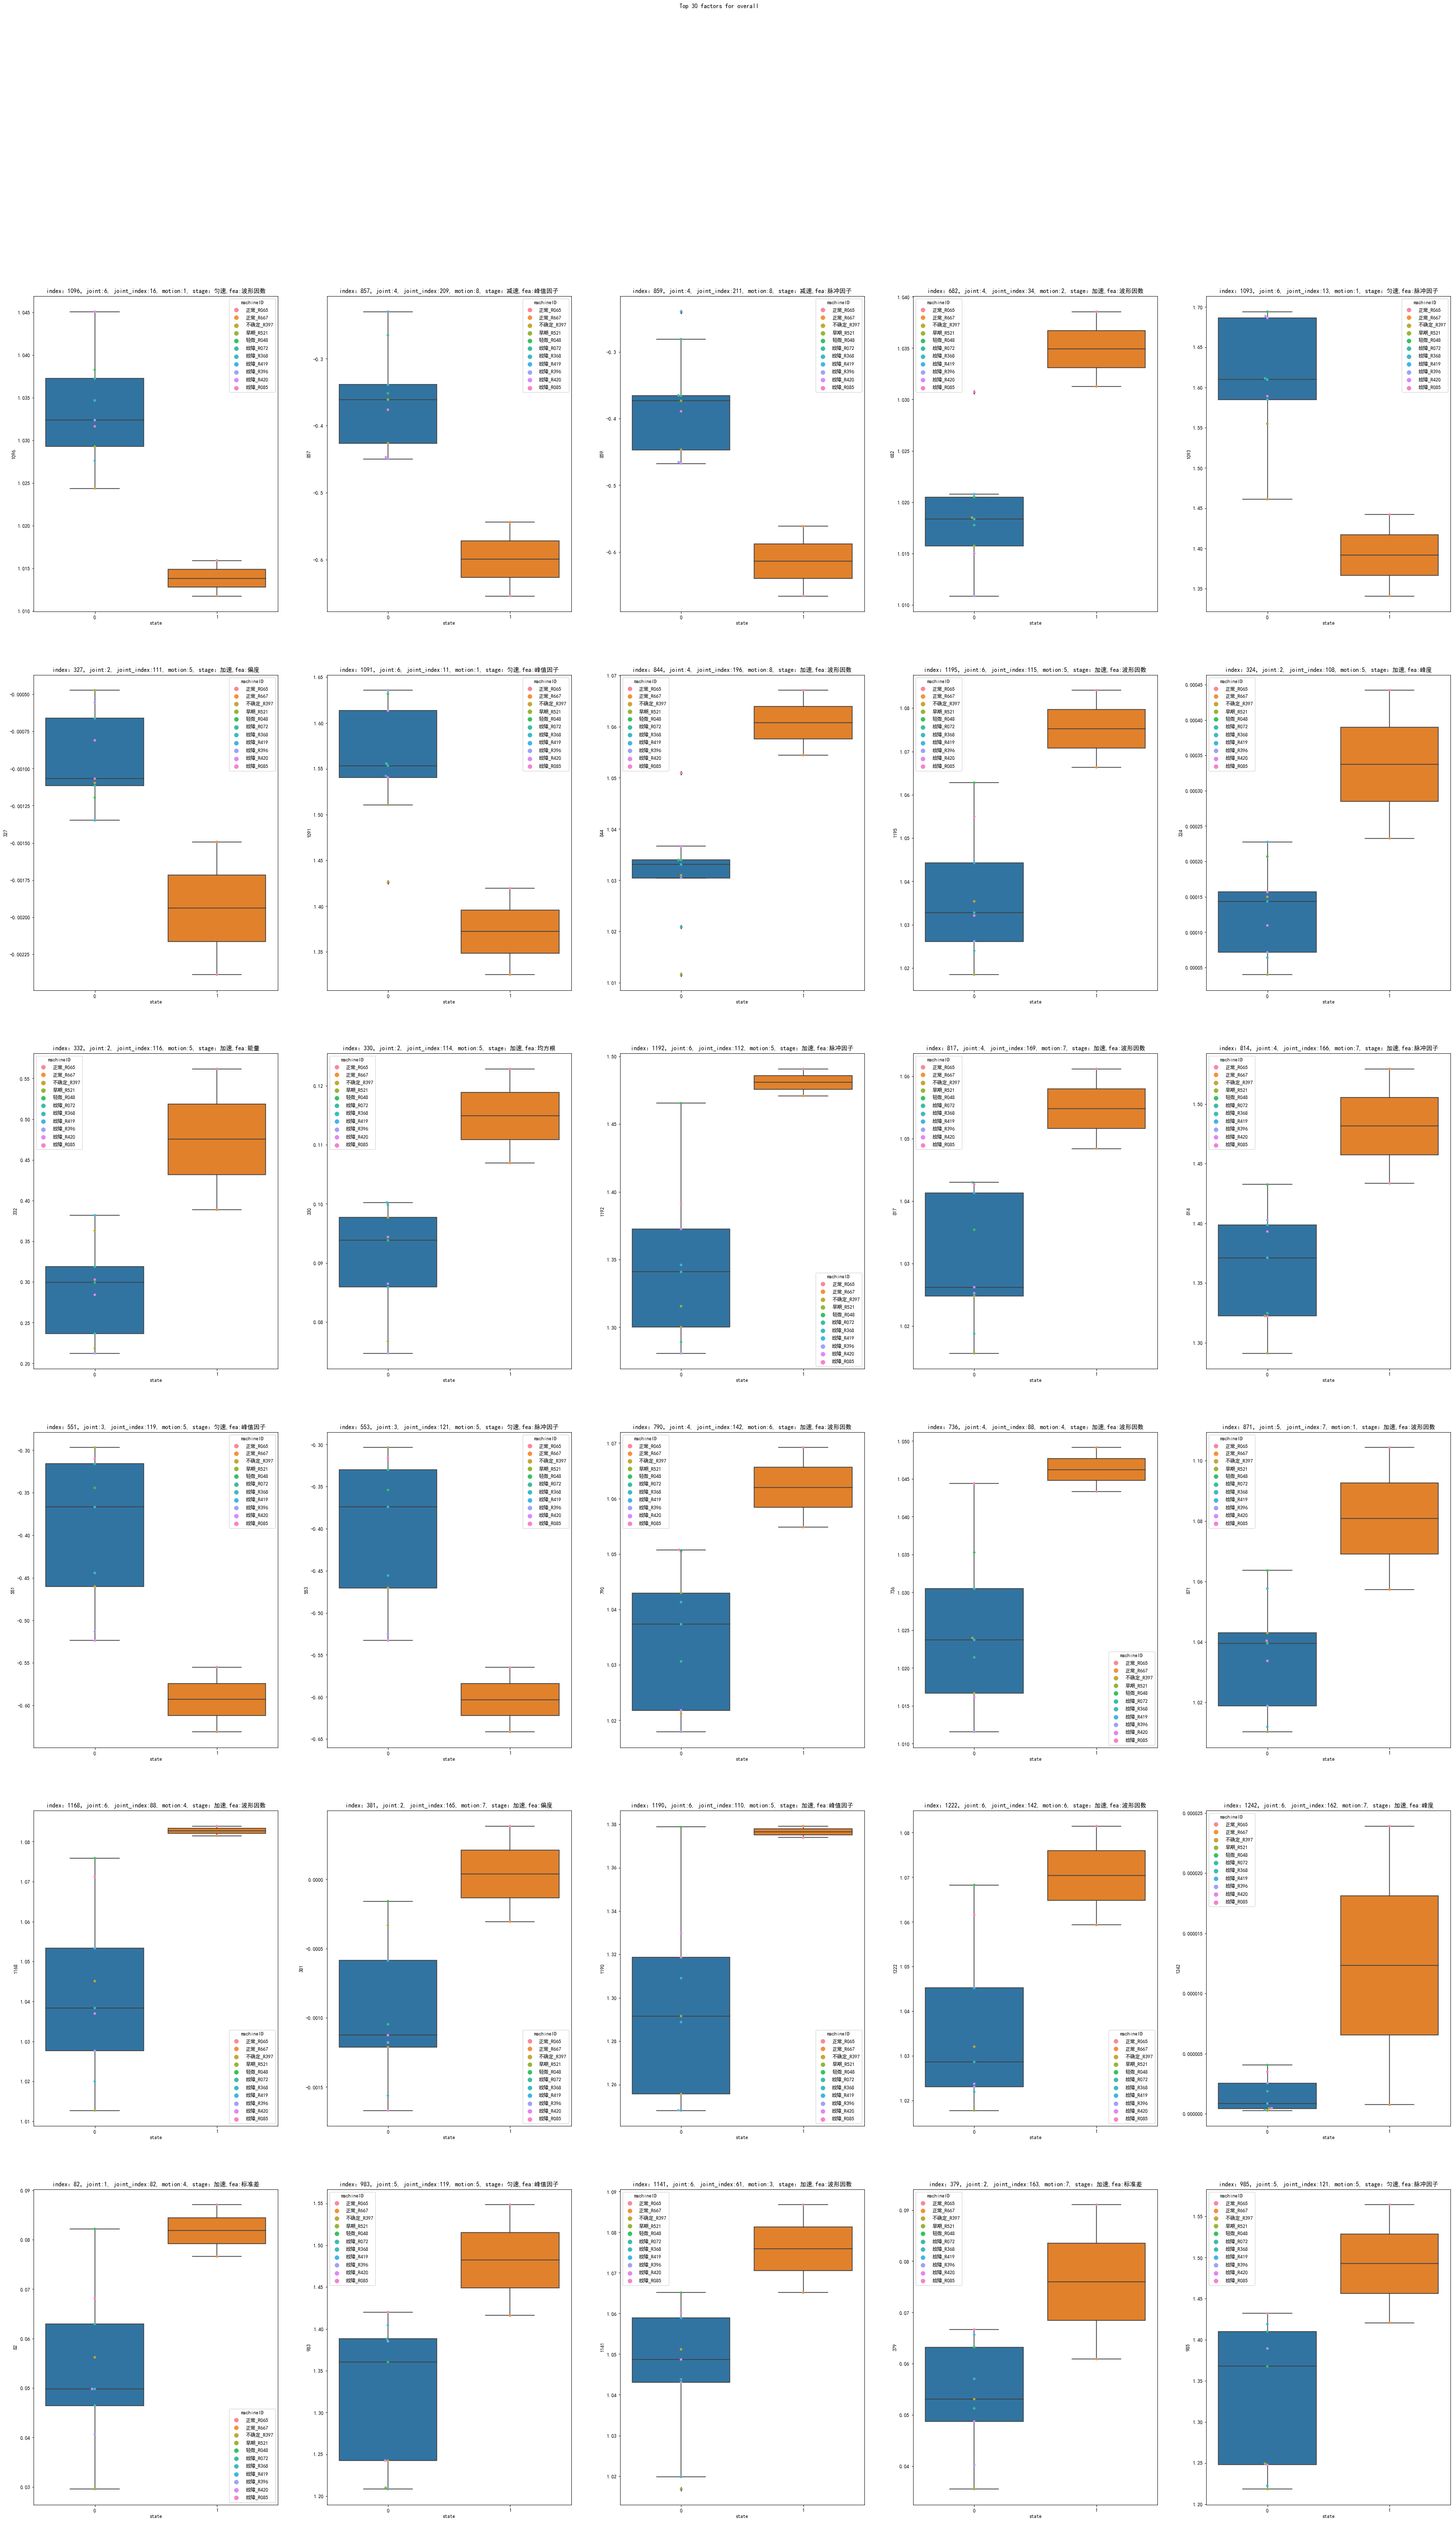

In [102]:
X = StandardScaler().fit_transform(n_df.drop(columns=['machineID','state']))
ob_df = pd.DataFrame(X)
dis_list = np.array(abs(np.mean(ob_df.loc[2:,:]) - np.mean(ob_df.loc[0:1,:])))
factor_index_list = np.argsort(-dis_list)

select_num = 30 # 取前select_num个
important_factor_list = factor_index_list[:select_num]
print(important_factor_list)
for factor in important_factor_list:
    print("index：{}，joint:{}, joint_index:{}, motion:{}, stage：{},fea:{}".format(
        factor,index_convert(factor)[0], factor-(index_convert(factor)[0]-1)*216, index_convert(factor)[1],
        index_convert(factor)[2],index_convert(factor)[3]))

#解决中文显示问题
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(50,80))
plt.suptitle('Top {} factors for overall'.format(select_num))
for i in tqdm(range(select_num)):
    factor = important_factor_list[i]
    ax = plt.subplot(6,5,i+1)
    ax = plt.title("index：{}，joint:{}, joint_index:{}, motion:{}, stage：{},fea:{}".format(
        factor,index_convert(factor)[0], factor-(index_convert(factor)[0]-1)*216, index_convert(factor)[1],
        index_convert(factor)[2],index_convert(factor)[3]))
    ax = sns.boxplot(x='state', y=important_factor_list[i], data=n_df)
    ax = sns.swarmplot(x='state', y=important_factor_list[i], hue="machineID", data=n_df)
plt.savefig("box_plot_joint_analysis_overall.png")


classification program

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
# from sklearn.inspection import DecisionBoundaryDisplay

names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]

# select the specific joint
X = df.drop(columns=['machineID','state'])
y = df['state']


X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3)

result_df = pd.DataFrame([])
# iterate over classifiers
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    result_df = result_df.append({'MODEL': name,'SCORE':score}, ignore_index=True)
    i += 1
result_df.sort_values(by="SCORE",ascending=False)

c:\Users\limer\Anaconda3\lib\site-packages\sklearn\neighbors\base.py:781: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self._y = np.empty(y.shape, dtype=np.int)
c:\Users\limer\Anaconda3\lib\site-packages\sklearn\tree\tree.py:149: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check t

,MODEL,SCORE
2,RBF SVM,0.90
1,Linear SVM,0.85
4,Decision Tree,0.85
6,Neural Net,0.85
9,QDA,0.85
0,Nearest Neighbors,0.80
5,Random Forest,0.80
7,AdaBoost,0.80
3,Gaussian Process,0.75
8,Naive Bayes,0.40


# 原始电流信号可视化

In [21]:
def index_convert(index):
    stage_name=['加速',"匀速","减速"]
    fea_name=['峰度','标准差','峰值因子',"偏度","脉冲因子","峰峰值","均方根","波形因数","能量"]

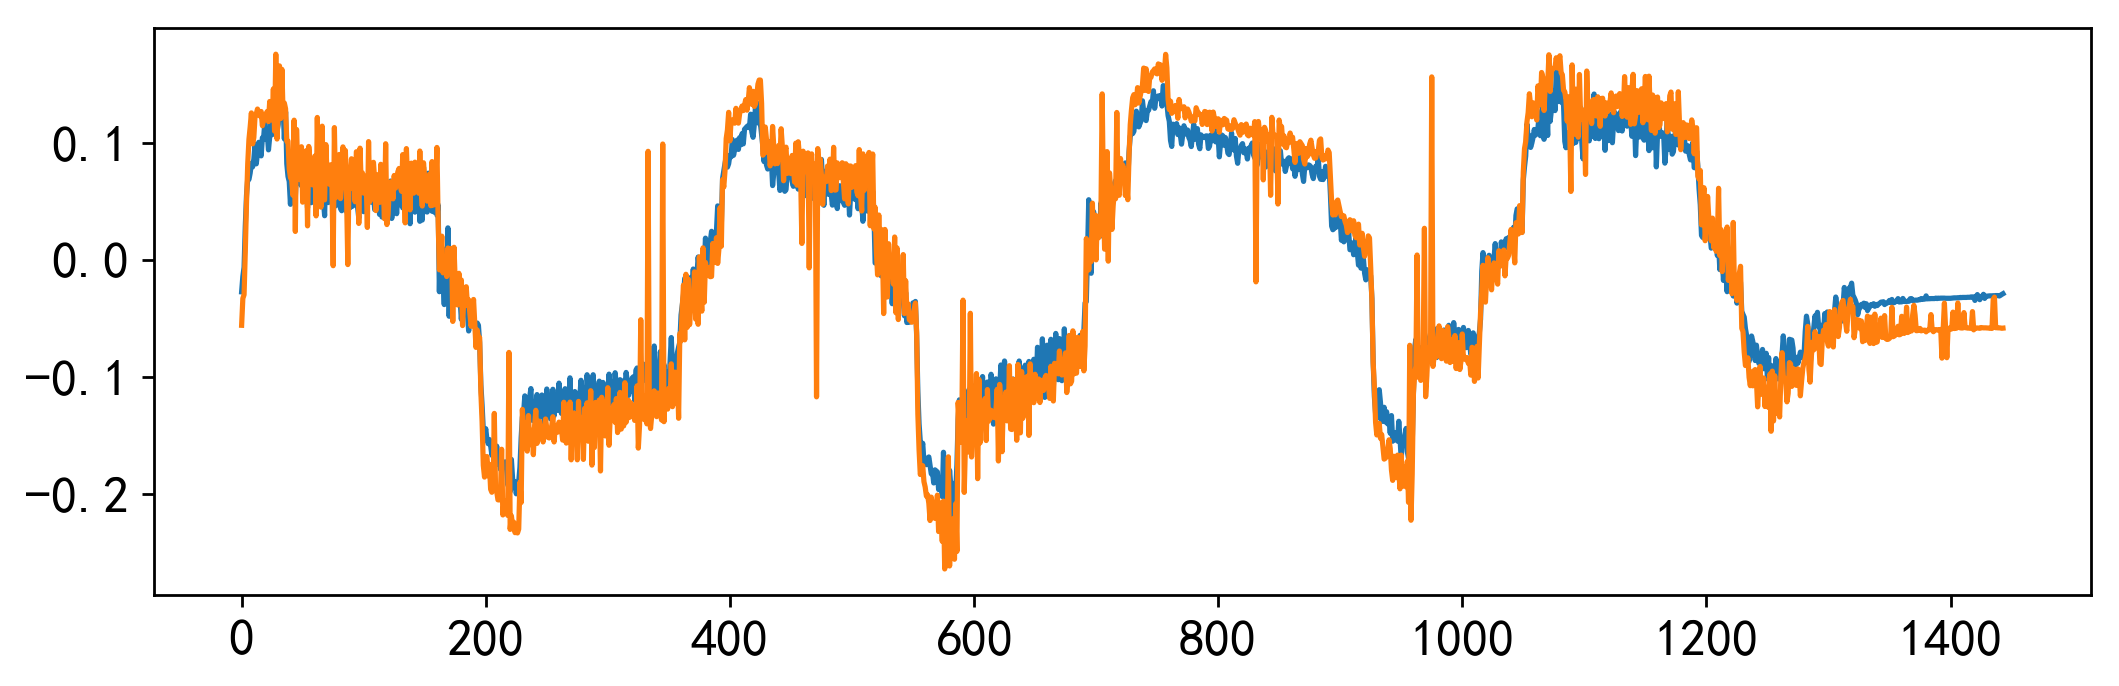

In [22]:
machine_total=np.array(['正常_R065','正常_R667','不确定_R397','早期_R521','轻微_R048','故障_R072','故障_R368','故障_R419','故障_R396','故障_R420','故障_R085'])
machine_std='正常_R667'
machine_test='故障_R085'

data=np.load('转矩周期原始数据.npy',allow_pickle=True).item()
joint=3
current_std=data[machine_std+'_转矩'][0,joint,:]
current_test=data[machine_test+'_转矩'][0,joint,:]

plt.figure(figsize=(10,3),dpi=250)
plt.plot(current_std,label='std')
plt.plot(current_test,label='test')
plt.show()



# 特征可视化

In [23]:
%matplotlib inline

In [24]:
machine_total=np.array(['正常_R065','正常_R667','不确定_R397','早期_R521','轻微_R048','故障_R072','故障_R368','故障_R419','故障_R396','','故障_R085'])
machine_std='正常_R667'
machine_test='故障_R085'

180


c:\Users\limer\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:2082: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


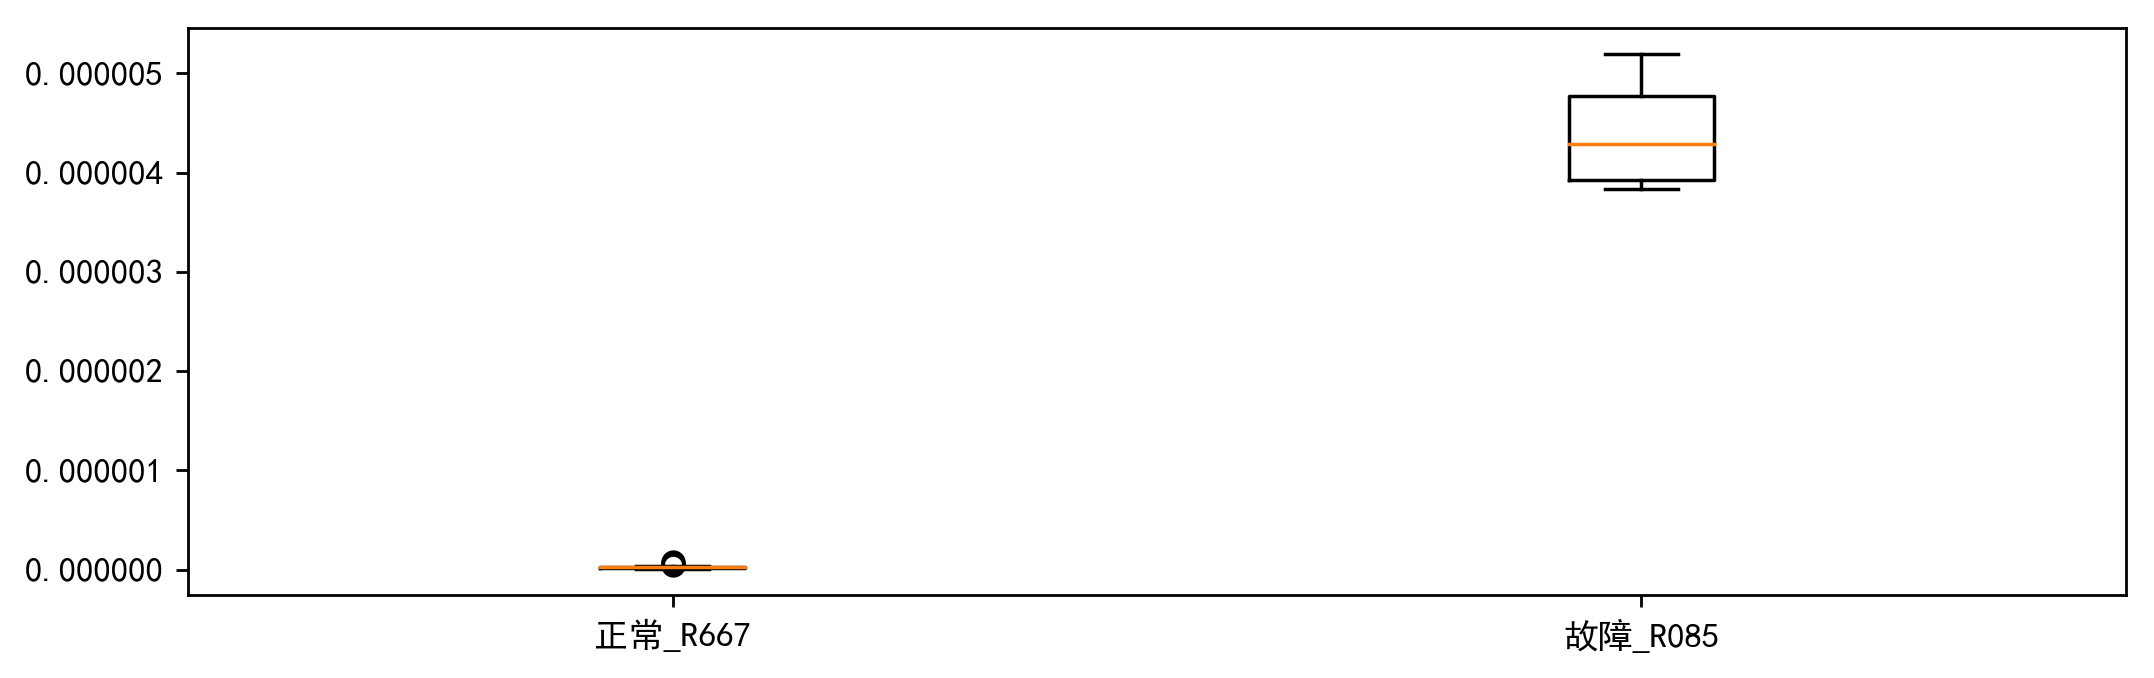

In [25]:
joint=1
motion=7
stage=3
fea=1
index=convert_index(joint,motion,stage,fea)
print(index)

fea_std=np.load(machine_std+'_电流.npz')['rotate_feas']
fea_std=fea_std.reshape(fea_std.shape[0],-1)[:,index]
fea_test=np.load(machine_test+'_电流.npz')['rotate_feas']
fea_test=fea_test.reshape(fea_test.shape[0],-1)[:,index]


plt.figure(figsize=(10,3),dpi=250)
plt.boxplot([fea_std,fea_test], labels = [machine_std,machine_test])
plt.show()

In [26]:
np.abs(np.mean(fea_test)-np.mean(fea_std))/np.abs(np.mean(fea_std))

160.06308092908384

In [27]:
fea_std=np.load(machine_std+'_电流.npz')['rotate_feas']
fea_std=fea_std.reshape(fea_std.shape[0],-1)
print(fea_std.shape)
fea_std=np.mean(fea_std,axis=0)
print(fea_std.shape)

(23, 1296)
(1296,)


In [28]:
fea_test=np.load(machine_test+'_电流.npz')['rotate_feas']
fea_test=fea_test.reshape(fea_test.shape[0],-1)
fea_test=np.mean(fea_test,axis=0)
print(fea_test.shape)

(1296,)


In [29]:
rate=np.abs(fea_test-fea_std)/np.abs(fea_std)
rate[180]

160.06308092908384

c:\Users\limer\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:2082: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


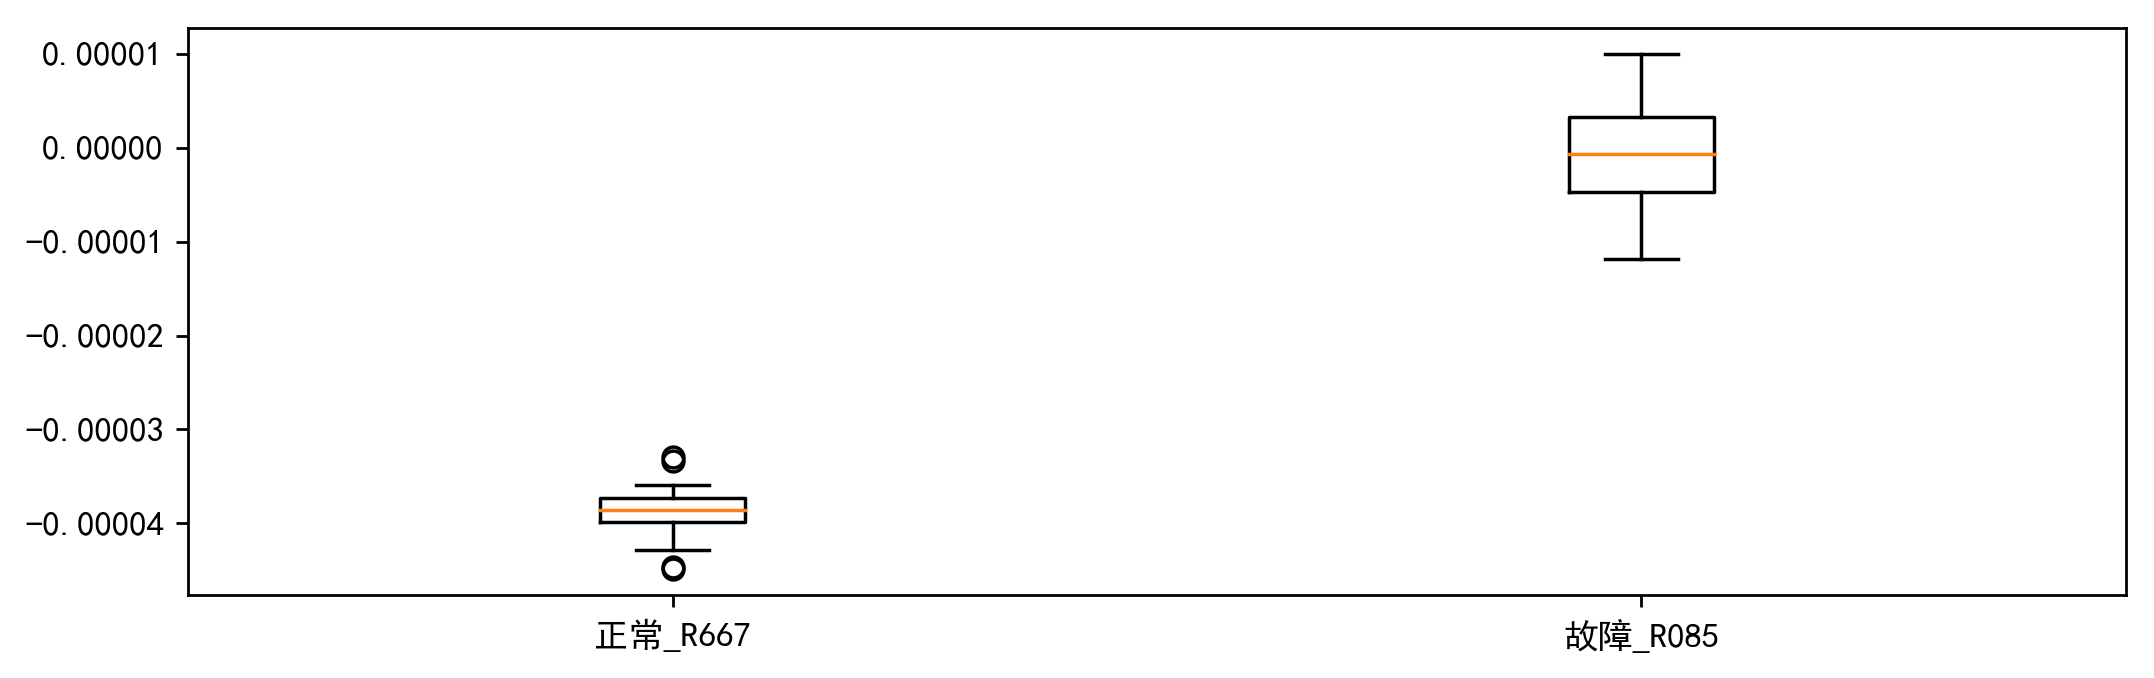

In [30]:
joint=4
motion=1
stage=3
fea=4
index=convert_index(joint,motion,stage,fea)

fea_std=np.load(machine_std+'_电流.npz')['rotate_feas']
fea_std=fea_std.reshape(fea_std.shape[0],-1)[:,index]
fea_test=np.load(machine_test+'_电流.npz')['rotate_feas']
fea_test=fea_test.reshape(fea_test.shape[0],-1)[:,index]

plt.figure(figsize=(10,3),dpi=250)
plt.boxplot([fea_std,fea_test], labels = [machine_std,machine_test])
plt.show()

In [31]:
np.abs(np.mean(fea_test)-np.mean(fea_std))/np.abs(np.mean(fea_std))

0.9797064398217421